# Modelo RNN

### Se importan librerías necesarias

In [1]:
import os
# os.environ["SM_FRAMEWORK"] = "tf.keras"
import pathlib
import numpy as np
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# import seaborn as sns
import datetime as dt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Flatten, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
# from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Conexión de google drive con el repo
# from google.colab import drive
# drive.mount('/content/drive')

###==========================
# ruta = os.path.join("/content/drive/MyDrive","MonografiaUdeA")
# os.chdir(ruta)
abspath = pathlib.Path.cwd()
print(f"Directorio de trabajo: {abspath}")
###==========================

Directorio de trabajo: d:\OneDrive\OneDrive - INTERCONEXION ELECTRICA S.A. E.S.P\Posgrado\EspecializacionAnalitica\Sem_2\06_monografia\MonografiaUdeA


In [3]:
def parse(x):
    return dt.datetime.strptime(x, '%Y-%m-%d')
dataset = pd.read_csv(os.path.join(abspath,"datasets", "procesado", "3_dataset_filtrado.csv"), index_col=0, date_parser=parse)
df = dataset.copy()
df.head(3)

,precio_bolsa,demanda,disp_dec_hidraulica,disp_dec_termica,gen_hidraulica,gen_no_termica,gen_termica,aportes_energia,precio_oferta,vol_util,indice_ONI,vertimientos
fecha,,,,,,,,,,,,
2010-01-01,120.501228,1.133616e+08,356125.000000,121611.607143,35796804.67,13362226.83,66260052.96,45616100.0,267.437633,1.000661e+10,1.5,0.0
2010-01-02,118.495340,1.254718e+08,353776.515152,121633.928571,46595646.99,13393741.63,67691806.16,43097100.0,277.153592,9.995147e+09,1.5,0.0
2010-01-03,121.160145,1.211452e+08,356579.545455,119455.357143,42578875.20,13046074.83,68012828.41,43400400.0,313.552755,9.992677e+09,1.5,0.0


In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [5]:
scaler = MinMaxScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
scaled_df.head(5)

,precio_bolsa,demanda,disp_dec_hidraulica,disp_dec_termica,gen_hidraulica,gen_no_termica,gen_termica,aportes_energia,precio_oferta,vol_util,indice_ONI,vertimientos
fecha,,,,,,,,,,,,
2010-01-01,0.044641,0.000000,0.654490,0.612788,0.000000,0.755503,0.665266,0.029498,0.144822,0.484812,0.738095,0.0
2010-01-02,0.043589,0.120600,0.645406,0.613112,0.074578,0.757482,0.682814,0.025017,0.162552,0.483498,0.738095,0.0
2010-01-03,0.044986,0.077513,0.656248,0.581456,0.046838,0.735654,0.686748,0.025557,0.228976,0.483215,0.738095,0.0
2010-01-04,0.046456,0.304433,0.598374,0.540133,0.182635,0.742847,0.717898,0.020238,0.210667,0.480082,0.738095,0.0
2010-01-05,0.044727,0.363560,0.615809,0.540155,0.230502,0.827840,0.692230,0.021626,0.276509,0.475660,0.738095,0.0


In [6]:
scaled_df.tail(5)

,precio_bolsa,demanda,disp_dec_hidraulica,disp_dec_termica,gen_hidraulica,gen_no_termica,gen_termica,aportes_energia,precio_oferta,vol_util,indice_ONI,vertimientos
fecha,,,,,,,,,,,,
2019-12-27,0.155485,0.845458,0.110515,0.354955,0.616507,0.174390,0.642084,0.126770,0.217813,0.619055,0.5,0.000000
2019-12-28,0.127943,0.784855,0.109813,0.359922,0.653376,0.223659,0.499929,0.092333,0.224686,0.613493,0.5,0.000000
2019-12-29,0.110686,0.659665,0.120313,0.397399,0.584269,0.171299,0.473201,0.088551,0.253386,0.608943,0.5,0.000000
2019-12-30,0.151277,0.765573,0.098931,0.432077,0.644047,0.237375,0.494649,0.145244,0.230048,0.607142,0.5,0.000000
2019-12-31,0.125619,0.611236,0.119057,0.392498,0.538956,0.200925,0.488179,0.246500,0.249581,0.613121,0.5,0.065609


### División de datos en entrenamiento y prueba

In [7]:
def create_sequences(data, n_lag, target_column):
    sequences = []
    targets = []
    for i in range(len(data) - n_lag):
        seq = data[i:i + n_lag]
        target = data[i + n_lag][target_column]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

def split_data(lags, scaled_df, train_test_split_ratio = 0.7):
  lagged_data = {}
  for lag in lags:
      X, y = create_sequences(scaled_df.values, lag, target_column=0)
      lagged_data[lag] = (X, y)

  train_test_split_ratio = train_test_split_ratio
  split_idx = int(len(scaled_df) * train_test_split_ratio)

  train_data = {lag: (X[:split_idx], y[:split_idx]) for lag, (X, y) in lagged_data.items()}
  test_data = {lag: (X[split_idx:], y[split_idx:]) for lag, (X, y) in lagged_data.items()}

  # lagged_data_no_var = {}
  # for lag in retardos:
  #     X, y = create_sequences(scaled_df.drop(columns=['precio_bolsa']).values, lag, target_column=0)
  #     lagged_data_no_var[lag] = (X, y)

  # train_data_no_var = {lag: (X[:split_idx], y[:split_idx]) for lag, (X, y) in lagged_data_no_var.items()}
  # test_data_no_var = {lag: (X[split_idx:], y[split_idx:]) for lag, (X, y) in lagged_data_no_var.items()}

  return train_data, test_data#, train_data_no_var, test_data_no_var

def get_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return mae, mse, mape, rmse

In [8]:
def create_model(model_type, input_shape, elements_to_predict, optimizer, loss, neuronas = 20):

    model = Sequential()
    if model_type == 'RNN':
        model.add(SimpleRNN(neuronas, input_shape=input_shape))
        model.add(Flatten())
        model.add(Dropout(0.3))
        model.add(Dense(20, activation='relu'))
        model.add(Dropout(0.3))

    elif model_type == 'DNN':
        model.add(Dense(neuronas, input_shape=input_shape))
        # model.add(LSTM(20))
        model.add(Flatten())
        model.add(Dropout(0.3))
        model.add(Dense(20, activation='relu'))
        model.add(Dropout(0.3))

    elif model_type == 'LSTM':
        model.add(LSTM(neuronas, input_shape=input_shape))
        model.add(Flatten())
        model.add(Dropout(0.3))
        model.add(Dense(20, activation='relu'))
        model.add(Dropout(0.3))

    elif model_type == 'GRU':
        model.add(GRU(neuronas, input_shape=input_shape))
        model.add(Flatten())
        model.add(Dropout(0.3))
        model.add(Dense(20, activation='relu'))
        model.add(Dropout(0.3))

    # model.add(Dense(elements_to_predict))
    model.add(Dense(1))
    model.compile(optimizer = optimizer, loss = loss)
    print(f"Model {model_type} created. Params -> input_shape: {input_shape}, elements_to_predict: {elements_to_predict}, optimizer: {optimizer}, loss: {loss}")
    return model

In [9]:
retardos = [60]
neurons = [25]
modelos_implementar = ['RNN']
metricas = ['MAE', 'MAPE', 'MSE', 'RMSE']
elementos_a_predecir = [30]
optimizers = ['adam']
losses = ['mse']
epochs = [30]
batch_size = [32]

In [10]:
train_data, test_data = split_data(lags = retardos, scaled_df = scaled_df, train_test_split_ratio = 0.8)

In [11]:
for retardo in retardos:
    print("retardo",retardo, "dimensiones",train_data[retardo][0].shape, test_data[retardo][0].shape)

retardo 60 dimensiones (2921, 60, 12) (671, 60, 12)


In [12]:
#Se inicializa la semilla
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
tf.compat.v1.set_random_seed(42)

models_with_var = {lag: {} for lag in retardos}

In [13]:
# Create arrays to represent parameter combinations
lag_grid, model_grid, optimizer_grid, loss_grid, element_grid, neurons_grid = np.meshgrid(retardos, modelos_implementar, optimizers, losses, elementos_a_predecir, neurons)
lag_grid = lag_grid.flatten()
model_grid = model_grid.flatten()
optimizer_grid = optimizer_grid.flatten()
loss_grid = loss_grid.flatten()
element_grid = element_grid.flatten()
neurons_grid = neurons_grid.flatten()

In [14]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

early_stopping = EarlyStopping(monitor='loss', patience = 10, restore_best_weights=True)

model_summary_df = pd.DataFrame()
index = 0
for model, lag, element_to_predict, optimizer, loss, neurons  in zip(model_grid, lag_grid, element_grid, optimizer_grid, loss_grid, neurons_grid):

    input_shape = train_data[lag][0].shape[1:]
    models_with_var[lag][model] = create_model(model, input_shape, elements_to_predict=element_to_predict, optimizer=optimizer, loss=loss, neuronas= neurons)
    for epoch in epochs:
        for batch in batch_size:
            print(f"modelo: {model}, neuronas: {neurons},lag: {lag}, elementos: {element_to_predict}, optimizador: {optimizer}, perdida: {loss}, epoch: {epoch}, batch: {batch}")
            index = index + 1
            _model = models_with_var[lag][model]
            X_train, y_train = train_data[lag]
            X_test, y_test = test_data[lag]
            history = _model.fit(
                X_train, y_train,
                epochs=epoch, batch_size=batch,
                validation_split=0.2,
                callbacks=[early_stopping],
                verbose=0
            )
            y_pred = _model.predict(X_test)
            X_train_rescaled = scaler.inverse_transform(np.hstack((X_train[:, -1, 0].reshape(-1,1),X_train[:, -1, 1:])))[:,0]
            y_pred_rescaled = scaler.inverse_transform(np.hstack((y_pred,X_test[:, -1, 1:])))[:,0]
            y_test_rescaled = scaler.inverse_transform(np.hstack((X_test[:, -1, 0].reshape(-1,1),X_test[:, -1, 1:])))[:,0]


            _model.save(os.path.join(abspath,"models","baseline",model, f'{model}_{index}.h5'))
            mse = mean_squared_error(y_test[-int(element_to_predict):], y_pred[-int(element_to_predict):])
            mae = mean_absolute_error(y_test[-int(element_to_predict):], y_pred[-int(element_to_predict):])
            rmse = mean_squared_error(y_test[-int(element_to_predict):], y_pred[-int(element_to_predict):], squared=False)
            mape = mean_absolute_percentage_error(y_test[-int(element_to_predict):], y_pred[-int(element_to_predict):])
            model_summary_df = pd.concat([model_summary_df, pd.DataFrame( {
                'id': index,
                'Modelo': model,
                'Neuronas': neurons,
                'LookBack': lag,
                'Elementos': element_to_predict,
                'Optimizador': optimizer,
                'Epocas': epoch,
                'BatchSize': batch,
                'MAE': mae,
                'MSE': mse,
                'RMSE': rmse,
                'MAPE': mape,
            }, index = [index])] )


Model RNN created. Params -> input_shape: (60, 12), elements_to_predict: 30, optimizer: adam, loss: mse
modelo: RNN, neuronas: 25,lag: 60, elementos: 30, optimizador: adam, perdida: mse, epoch: 30, batch: 32

21/21 [==============================] - 0s 3ms/step


In [15]:
model_summary_df.to_csv(os.path.join(abspath,"models", "results",f"7_baseline_{modelos_implementar[0]}_model_results.csv"))
model_summary_df.head()

,id,Modelo,Neuronas,LookBack,Elementos,Optimizador,Epocas,BatchSize,MAE,MSE,RMSE,MAPE
1,1,RNN,25,60,30,adam,30,32,0.025244,0.000853,0.029211,19.677167


In [16]:
best_model = model_summary_df[model_summary_df['MSE'] == model_summary_df['MSE'].min()]
best_model

,id,Modelo,Neuronas,LookBack,Elementos,Optimizador,Epocas,BatchSize,MAE,MSE,RMSE,MAPE
1,1,RNN,25,60,30,adam,30,32,0.025244,0.000853,0.029211,19.677167


### Se carga el mejor modelo

In [17]:
best_model_saved =load_model(os.path.join(abspath,"models","baseline",f'{modelos_implementar[0]}', f'{modelos_implementar[0]}_{best_model["id"].values[0]}.h5'))
best_model_saved.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 25)                950       
                                                                 
 flatten (Flatten)           (None, 25)                0         
                                                                 
 dropout (Dropout)           (None, 25)                0         
                                                                 
 dense (Dense)               (None, 20)                520       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1491 (5.82 KB)
Trainable params: 1491 (5.8

In [18]:
X_train, y_train = train_data[best_model["LookBack"].values[0]]
X_test, y_test = test_data[best_model["LookBack"].values[0]]

### Predicciones con el mejor modelo

In [19]:
 y_pred = best_model_saved.predict(X_test)
X_train_rescaled = scaler.inverse_transform(np.hstack((X_train[:, -1, 0].reshape(-1,1),X_train[:, -1, 1:])))[:,0]
y_pred_rescaled = scaler.inverse_transform(np.hstack((y_pred,X_test[:, -1, 1:])))[:,0]
y_test_rescaled = scaler.inverse_transform(np.hstack((X_test[:, -1, 0].reshape(-1,1),X_test[:, -1, 1:])))[:,0]

21/21 [==============================] - 0s 3ms/step


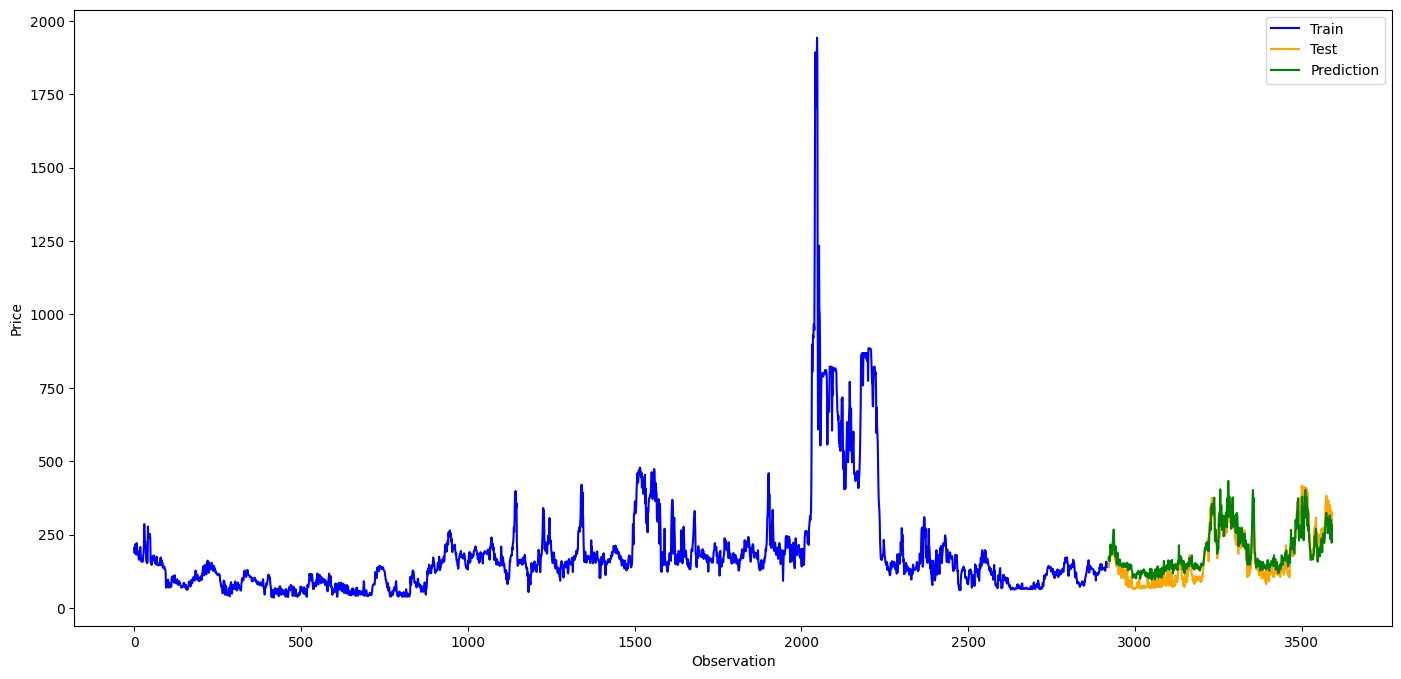

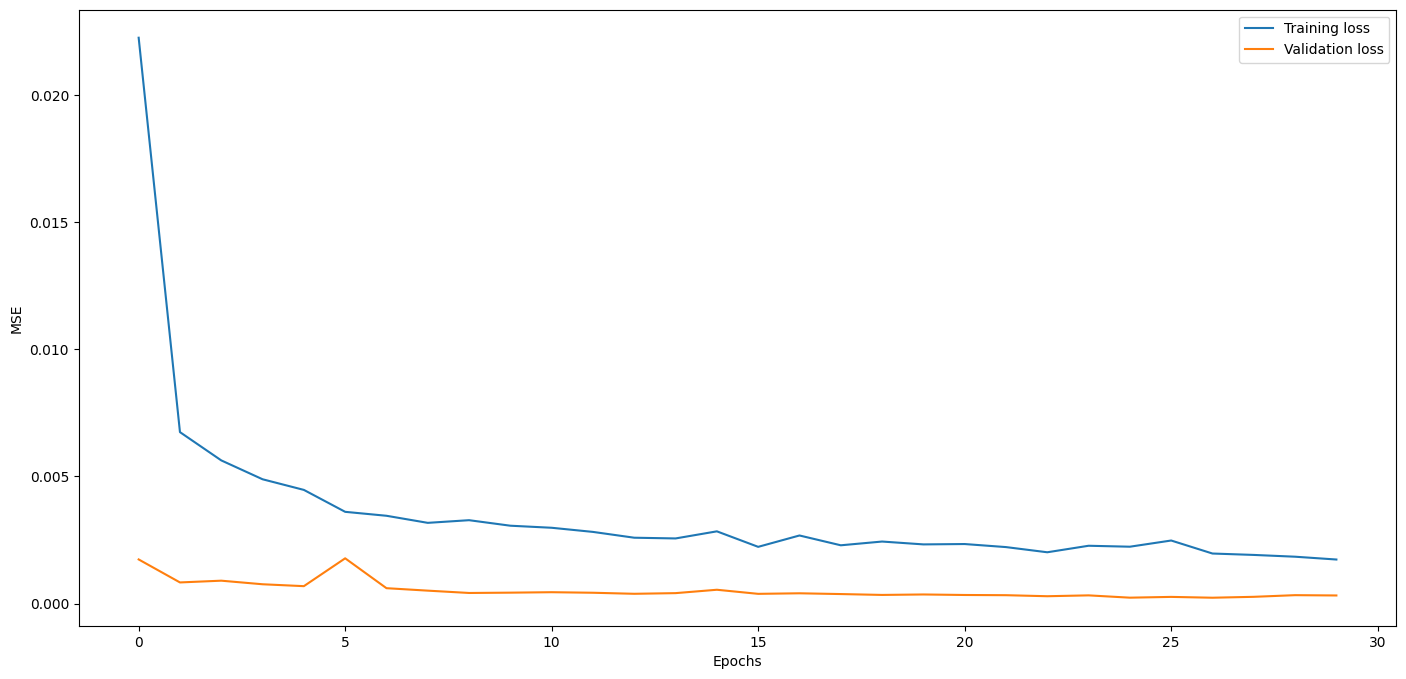

In [20]:
plt.figure(figsize=(17,8))
plt.plot(X_train_rescaled, label='Train', color='blue')
plt.plot(np.arange(len(X_train_rescaled), len(X_train_rescaled) + len(y_test_rescaled)), y_test_rescaled, label='Test', color='orange')
plt.plot(np.arange(len(X_train_rescaled), len(X_train_rescaled) + len(y_pred_rescaled)), y_pred_rescaled, label='Prediction', color='green')
plt.xlabel('Observation')
plt.ylabel('Price')
plt.legend()
plt.show()

plt.figure(figsize=(17,8))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')

plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [21]:
index = dataset.iloc[dataset.shape[0] - len(y_test_rescaled):, 0].index
predictions_df = pd.DataFrame(data = {'Precio de Bolsa Original': y_test_rescaled, 'Precio de Bolsa Predicho': y_pred_rescaled}, index = index)
predictions_df = predictions_df.iloc[-31: , :]
predictions_df.to_csv(os.path.join(abspath,"models", "results",f"7_baseline_{modelos_implementar[0]}_prediction.csv"))
predictions_df

,Precio de Bolsa Original,Precio de Bolsa Predicho
fecha,,
2019-12-01,249.978260,191.209662
2019-12-02,217.336295,190.324971
2019-12-03,271.575618,231.371761
2019-12-04,271.912097,246.741253
2019-12-05,269.907110,253.658782
2019-12-06,223.981190,246.851586
2019-12-07,257.714490,223.777274
2019-12-08,260.535417,222.132805
2019-12-09,266.723857,236.239856
